In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from jcopml.tuning import random_search_params as rsp
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor, XGBClassifier
import joblib
import time

In [88]:
# Load the dataset
df = pd.read_csv('Data_XGBoost.csv',sep=';')
df

,minute_timestamp,Pac_pvlib,solarRad,outsideTemp,outsideHumidity,windSpeed,solar_azimuth,Pac,Op_GriSwStt,GridMs_Hz,cos_theta
0,01/09/2022 00:00,0.0,0,20.5,91,0.0,-9.340480e-16,0,Grid-tie,48.99,0.0
1,01/09/2022 00:01,0.0,0,20.5,91,0.0,-3.327930e-02,0,Grid-tie,48.99,0.0
2,01/09/2022 00:02,0.0,0,20.5,91,0.0,-6.655790e-02,0,Grid-tie,48.99,0.0
3,01/09/2022 00:03,0.0,0,20.5,91,0.0,-9.983514e-02,0,Grid-tie,48.99,0.0
4,01/09/2022 00:04,0.0,0,20.5,91,0.0,-1.331103e-01,0,Grid-tie,48.99,0.0
...,...,...,...,...,...,...,...,...,...,...,...
525595,31/08/2023 23:55,0.0,0,21.1,91,0.0,-3.126422e-01,0,Grid-tie,48.99,0.0
525596,31/08/2023 23:56,0.0,0,21.1,91,0.0,-2.501212e-01,0,Grid-tie,48.99,0.0
525597,31/08/2023 23:57,0.0,0,21.1,91,0.0,-1.875952e-01,0,Grid-tie,48.99,0.0
525598,31/08/2023 23:58,0.0,0,21.1,91,0.0,-1.250655e-01,0,Grid-tie,48.99,0.0


In [89]:
df.columns

Index(['minute_timestamp', 'Pac_pvlib', 'solarRad', 'outsideTemp',
       'outsideHumidity', 'windSpeed', 'solar_azimuth', 'Pac', 'Op_GriSwStt',
       'GridMs_Hz', 'cos_theta'],
      dtype='object')

In [90]:
# Check for null values
df.isna().sum()

minute_timestamp    0
Pac_pvlib           0
solarRad            0
outsideTemp         0
outsideHumidity     0
windSpeed           0
solar_azimuth       0
Pac                 0
Op_GriSwStt         0
GridMs_Hz           0
cos_theta           0
dtype: int64

In [91]:
# Periksa nilai unik dalam kolom 'Op_GriSwStt'
print(df['Op_GriSwStt'].unique())

['Grid-tie' 'Isolated']


In [92]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Op_GriSwStt'] = label_encoder.fit_transform(df['Op_GriSwStt'])


In [93]:
# Periksa nilai unik dalam kolom 'Op_GriSwStt'
print(df['Op_GriSwStt'].unique())

[0 1]


In [94]:
print(df.dtypes)

minute_timestamp     object
Pac_pvlib           float64
solarRad              int64
outsideTemp         float64
outsideHumidity       int64
windSpeed           float64
solar_azimuth       float64
Pac                   int64
Op_GriSwStt           int32
GridMs_Hz           float64
cos_theta           float64
dtype: object


# Datas set spliting

In [95]:
import time

# Mulai waktu
start_time = time.time()

df = df.set_index('minute_timestamp')
df.index = pd.to_datetime(df.index)

# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 120.21907997131348 seconds


import time

# Mulai waktu
start_time = time.time()

# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


In [96]:
# Create time series features
def create_features(df):
    df['month'] = df.index.month
    df['year'] = df.index.dayofyear
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.day

    return df

df = create_features(df)

In [97]:
#test.describe()

In [98]:
# Split the data into training and testing sets
split_date1 = '2023-04-30 23:59:00'
split_date2 = '2023-06-30 23:59:00'
train = df.loc[df.index <= split_date1].copy()
test = df.loc[(df.index > split_date1)&(df.index < split_date2)].copy()
validasi = df.loc[(df.index > split_date2) &(df.index < '2023-08-31 23:59:00')].copy()

In [99]:
# Training set untuk regresi
X_train_reg = train.drop(columns=['Pac'])
y_train_reg = train['Pac']

# Test set untuk regresi
X_test_reg = test.drop(columns=['Pac'])
y_test_reg = test['Pac']

# Training set untuk klasifikasi
X_train_clf = train.drop(columns=['Op_GriSwStt'])
y_train_clf = train['Op_GriSwStt']

# Test set untuk klasifikasi
X_test_clf = test.drop(columns=['Op_GriSwStt'])
y_test_clf = test['Op_GriSwStt']

# Test set untuk regresi
X_validasi_reg = test.drop(columns=['Pac'])
y_validasi_reg = test['Pac']

# Test set untuk klasifikasi
X_validasi_clf = test.drop(columns=['Op_GriSwStt'])
y_validasi_clf = test['Op_GriSwStt']

In [100]:
X_train_reg.columns

Index(['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'Op_GriSwStt', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second'],
      dtype='object')

# Modelling

In [121]:
import time

# Mulai waktu
start_time = time.time()

# Fitur numerik untuk regresi
numeric_cols_reg = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']
#'A_Ms_Amp', 'A_Ms_Vol', 'A_Ms_Watt', 'B_Ms_Amp','B_Ms_Vol',
# Fitur kategorikal untuk regresi
categoric_cols_reg = ['Op_GriSwStt']

# Fitur numerik untuk klasifikasi
numeric_cols_clf = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']
#A_Ms_Amp', 'A_Ms_Vol', 'A_Ms_Watt', 'B_Ms_Amp', 'B_Ms_Vol',
# Preprocessor untuk regresi
preprocessor_reg = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_reg),
    ('categoric', OneHotEncoder(), categoric_cols_reg)
])

# Preprocessor untuk klasifikasi
preprocessor_clf = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_clf)
])
# Pipeline untuk regresi
pipeline_reg = Pipeline([
    ('prep', preprocessor_reg),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

# Pipeline untuk klasifikasi
pipeline_clf = Pipeline([
    ('prep', preprocessor_clf),
    ('algo', XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
])

# Fit model regresi
model_reg = RandomizedSearchCV(pipeline_reg, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_reg.fit(X_train_reg, y_train_reg)

# Print results for regresi
print("Regression Model Best Params:", model_reg.best_params_)
print("Regression Model Score:", model_reg.score(X_test_reg, y_test_reg))

# Fit model klasifikasi
model_clf = RandomizedSearchCV(pipeline_clf, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_clf.fit(X_train_clf, y_train_clf)

# Print results for klasifikasi
print("Classification Model Best Params:", model_clf.best_params_)
print("Classification Model Score:", model_clf.score(X_test_clf, y_test_clf))


# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Regression Model Best Params: {'algo__colsample_bytree': 0.43505448990556883, 'algo__gamma': 9, 'algo__learning_rate': 0.21232617602360485, 'algo__max_depth': 2, 'algo__n_estimators': 181, 'algo__reg_alpha': 0.08759009842205835, 'algo__reg_lambda': 0.062186565515225174, 'algo__subsample': 0.7972287313054105}
Regression Model Score: 0.9061139718591992
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Classification Model Best Params: {'algo__colsample_bytree': 0.7950202923669918, 'algo__gamma': 8, 'algo__learning_rate': 0.010257563974185648, 'algo__max_depth': 3, 'algo__n_estimators': 180, 'algo__reg_alpha': 0.7004349545230065, 'algo__reg_lambda': 1.4477786306928684, 'algo__subsample': 0.6029799873905057}
Classification Model Score: 0.943067912315413
Elapsed time: 1580.0164959430695 seconds


In [123]:

# Mulai waktu
start_time = time.time()

# Predictions for regresi
y_pred_reg = model_reg.predict(X_test_reg)

# Predictions for klasifikasi
y_pred_clf = model_clf.predict(X_test_clf)
# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 0.37176966667175293 seconds


In [124]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
absolute_percentage_error_reg = np.abs((y_test_reg - y_pred_reg) / np.maximum(np.abs(y_test_reg), 1)) * 100
mape_reg = np.mean(np.where(np.isfinite(absolute_percentage_error_reg), absolute_percentage_error_reg, 0))

rmse=np.sqrt(mean_squared_error(y_test_reg,y_pred_reg))
MAE=mean_absolute_error(y_test_reg, y_pred_reg)
print('RMSE prediksi/estimasi pada data tes=',rmse)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('Mean Absolute Percentage Error on Test Set: ', mape_reg, '%')
print("r2_score",r2_score(y_test_reg,y_pred_reg))
# Menghitung rata-rata dari data aktual dan hasil prediksi
actual_mean = np.mean(y_test_reg)
predicted_mean = np.mean(y_pred_reg)

# Menghitung bias
bias = actual_mean - predicted_mean

print('Rata-rata Actual:', actual_mean)
print('Rata-rata Predicted:', predicted_mean)
print('Bias:', bias)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Print classification results
# Evaluate classification model
accuracy_clf = accuracy_score(y_test_clf, y_pred_clf)
precision_clf = precision_score(y_test_clf, y_pred_clf)
recall_clf = recall_score(y_test_clf, y_pred_clf)
f1_clf = f1_score(y_test_clf, y_pred_clf)

print('Classification Model Metrics:')
print('Accuracy: ', accuracy_clf)
print('Precision: ', precision_clf)
print('Recall: ', recall_clf)
print('F1 Score: ', f1_clf)

RMSE prediksi/estimasi pada data tes= 121.81986487824868
MAE prekdisi/estimasi pada data tes= 60.86883201199362
Mean Absolute Percentage Error on Test Set:  546.6902034115815 %
r2_score 0.9061139718591992
Rata-rata Actual: 298.12709810139023
Rata-rata Predicted: 262.6583
Bias: 35.46880342365586
Classification Model Metrics:
Accuracy:  0.943067912315413
Precision:  0.8711531841652324
Recall:  0.9767648307537922
F1 Score:  0.9209410651576629


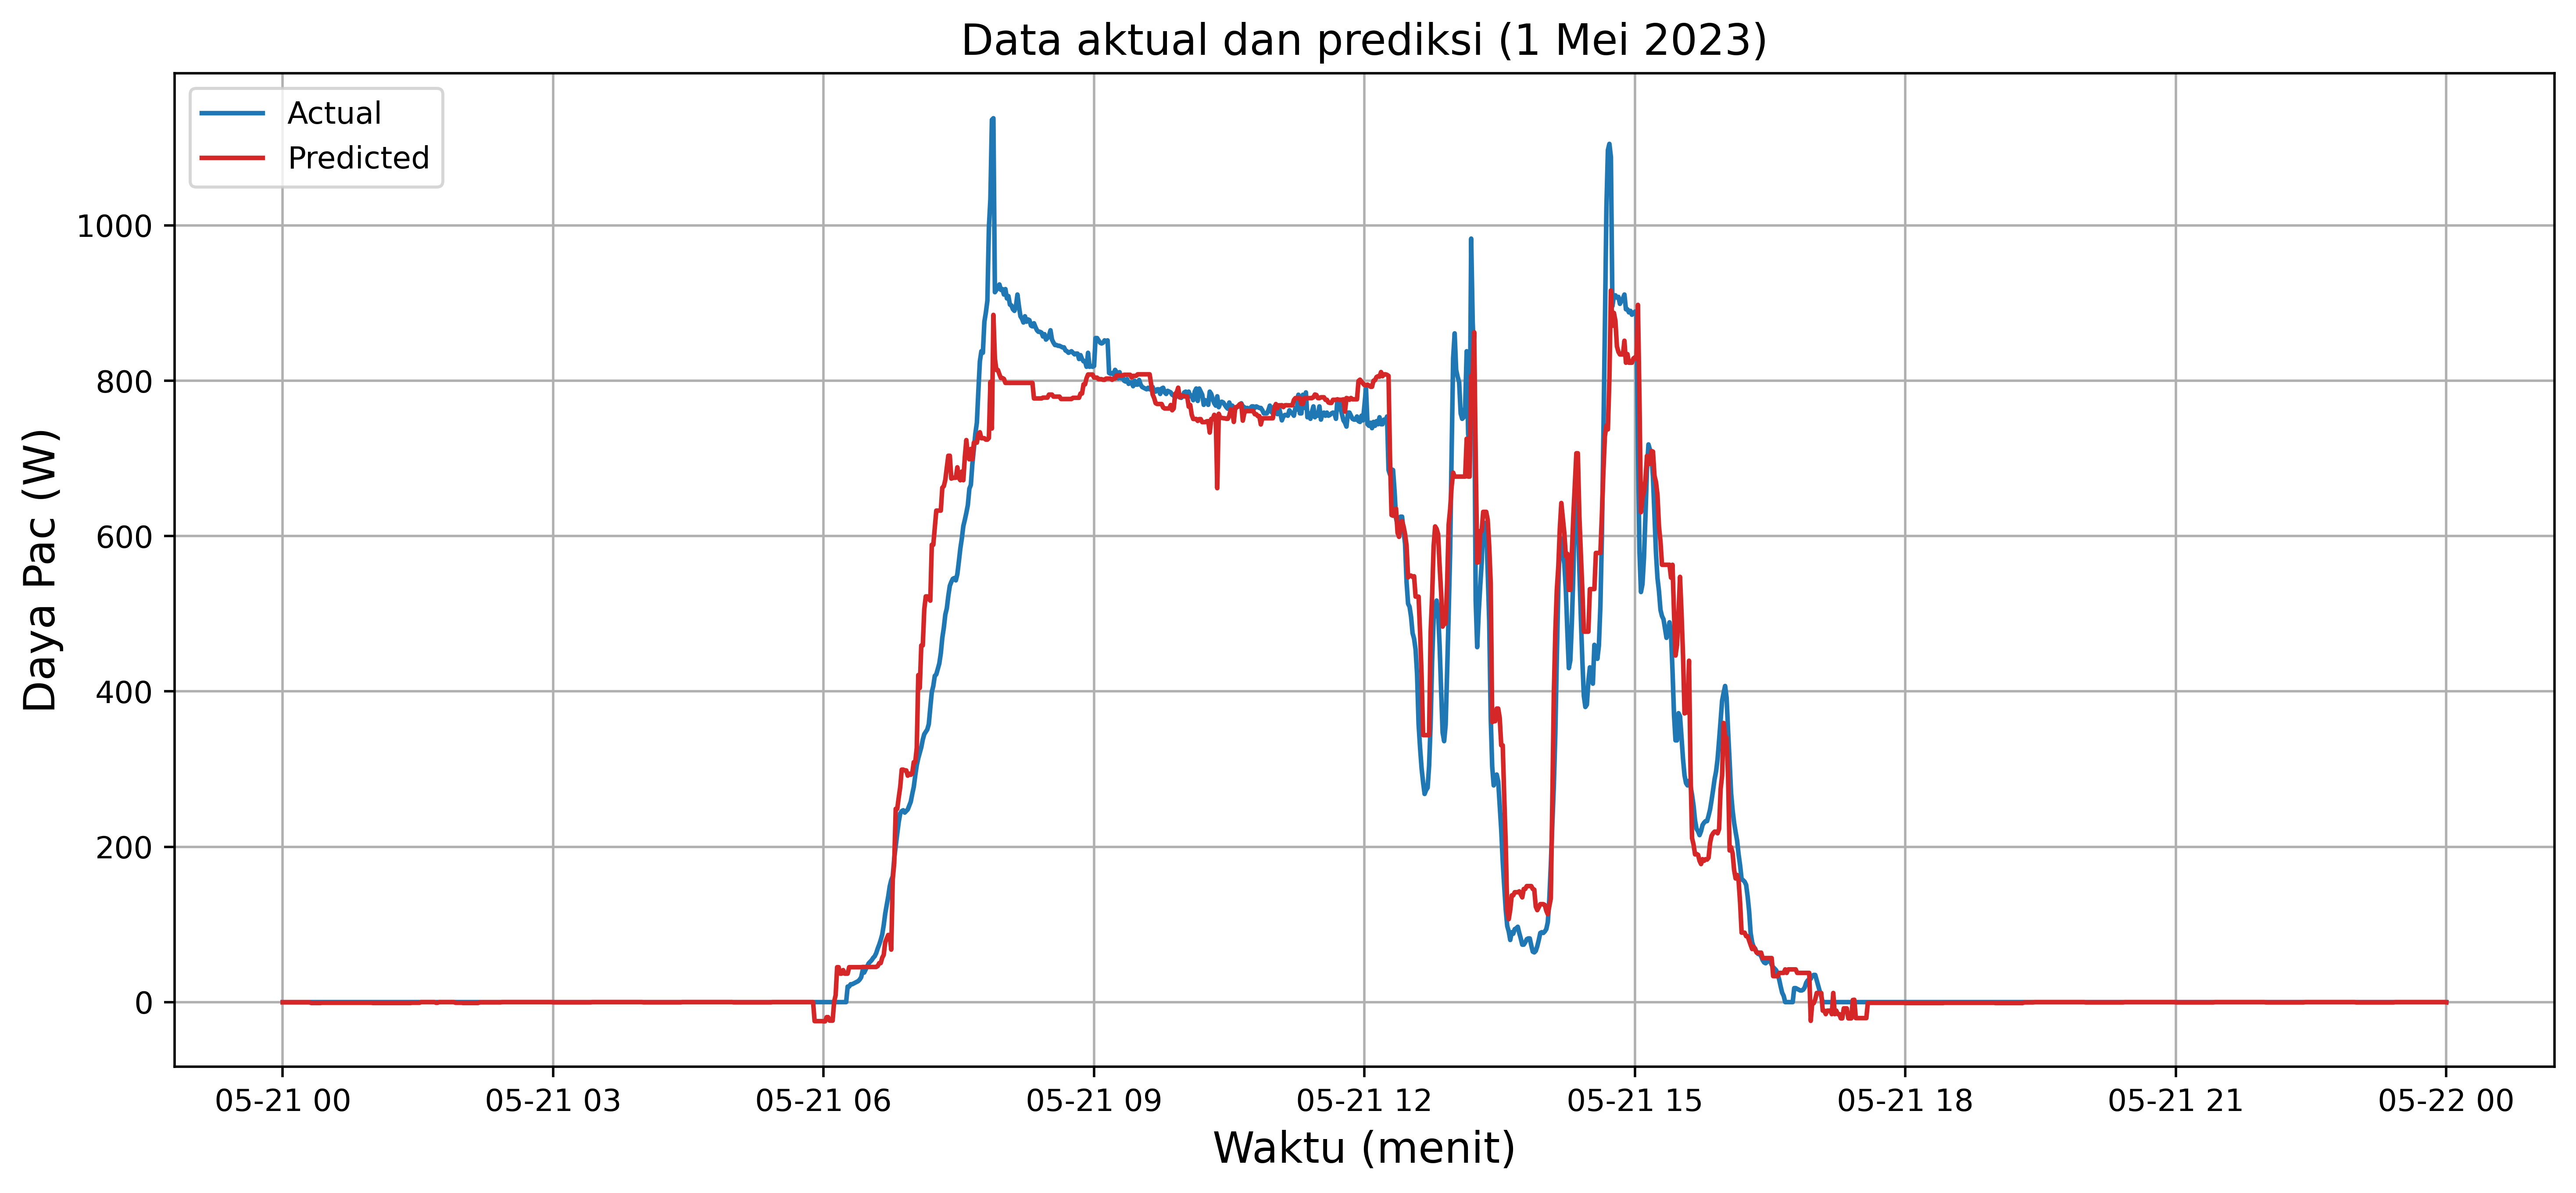

In [125]:
import matplotlib.pyplot as plt
import pandas as pd
# Prediksi status operasi untuk setiap dataset (X_test_reg dan X_test_clf)
y_pred_clf = model_clf.predict(X_test_reg)

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df = pd.DataFrame(y_pred_reg, index=y_test_reg.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_actual = y_test_reg[(y_test_reg.index >= start_date) & (y_test_reg.index <= end_date)]
filtered_predicted = y_pred_reg_df[(y_pred_reg_df.index >= start_date) & (y_pred_reg_df.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual.index, filtered_actual, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted.index, filtered_predicted.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (1 Mei 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
plt.savefig('Model1a.png')

# Menampilkan plot
plt.show()


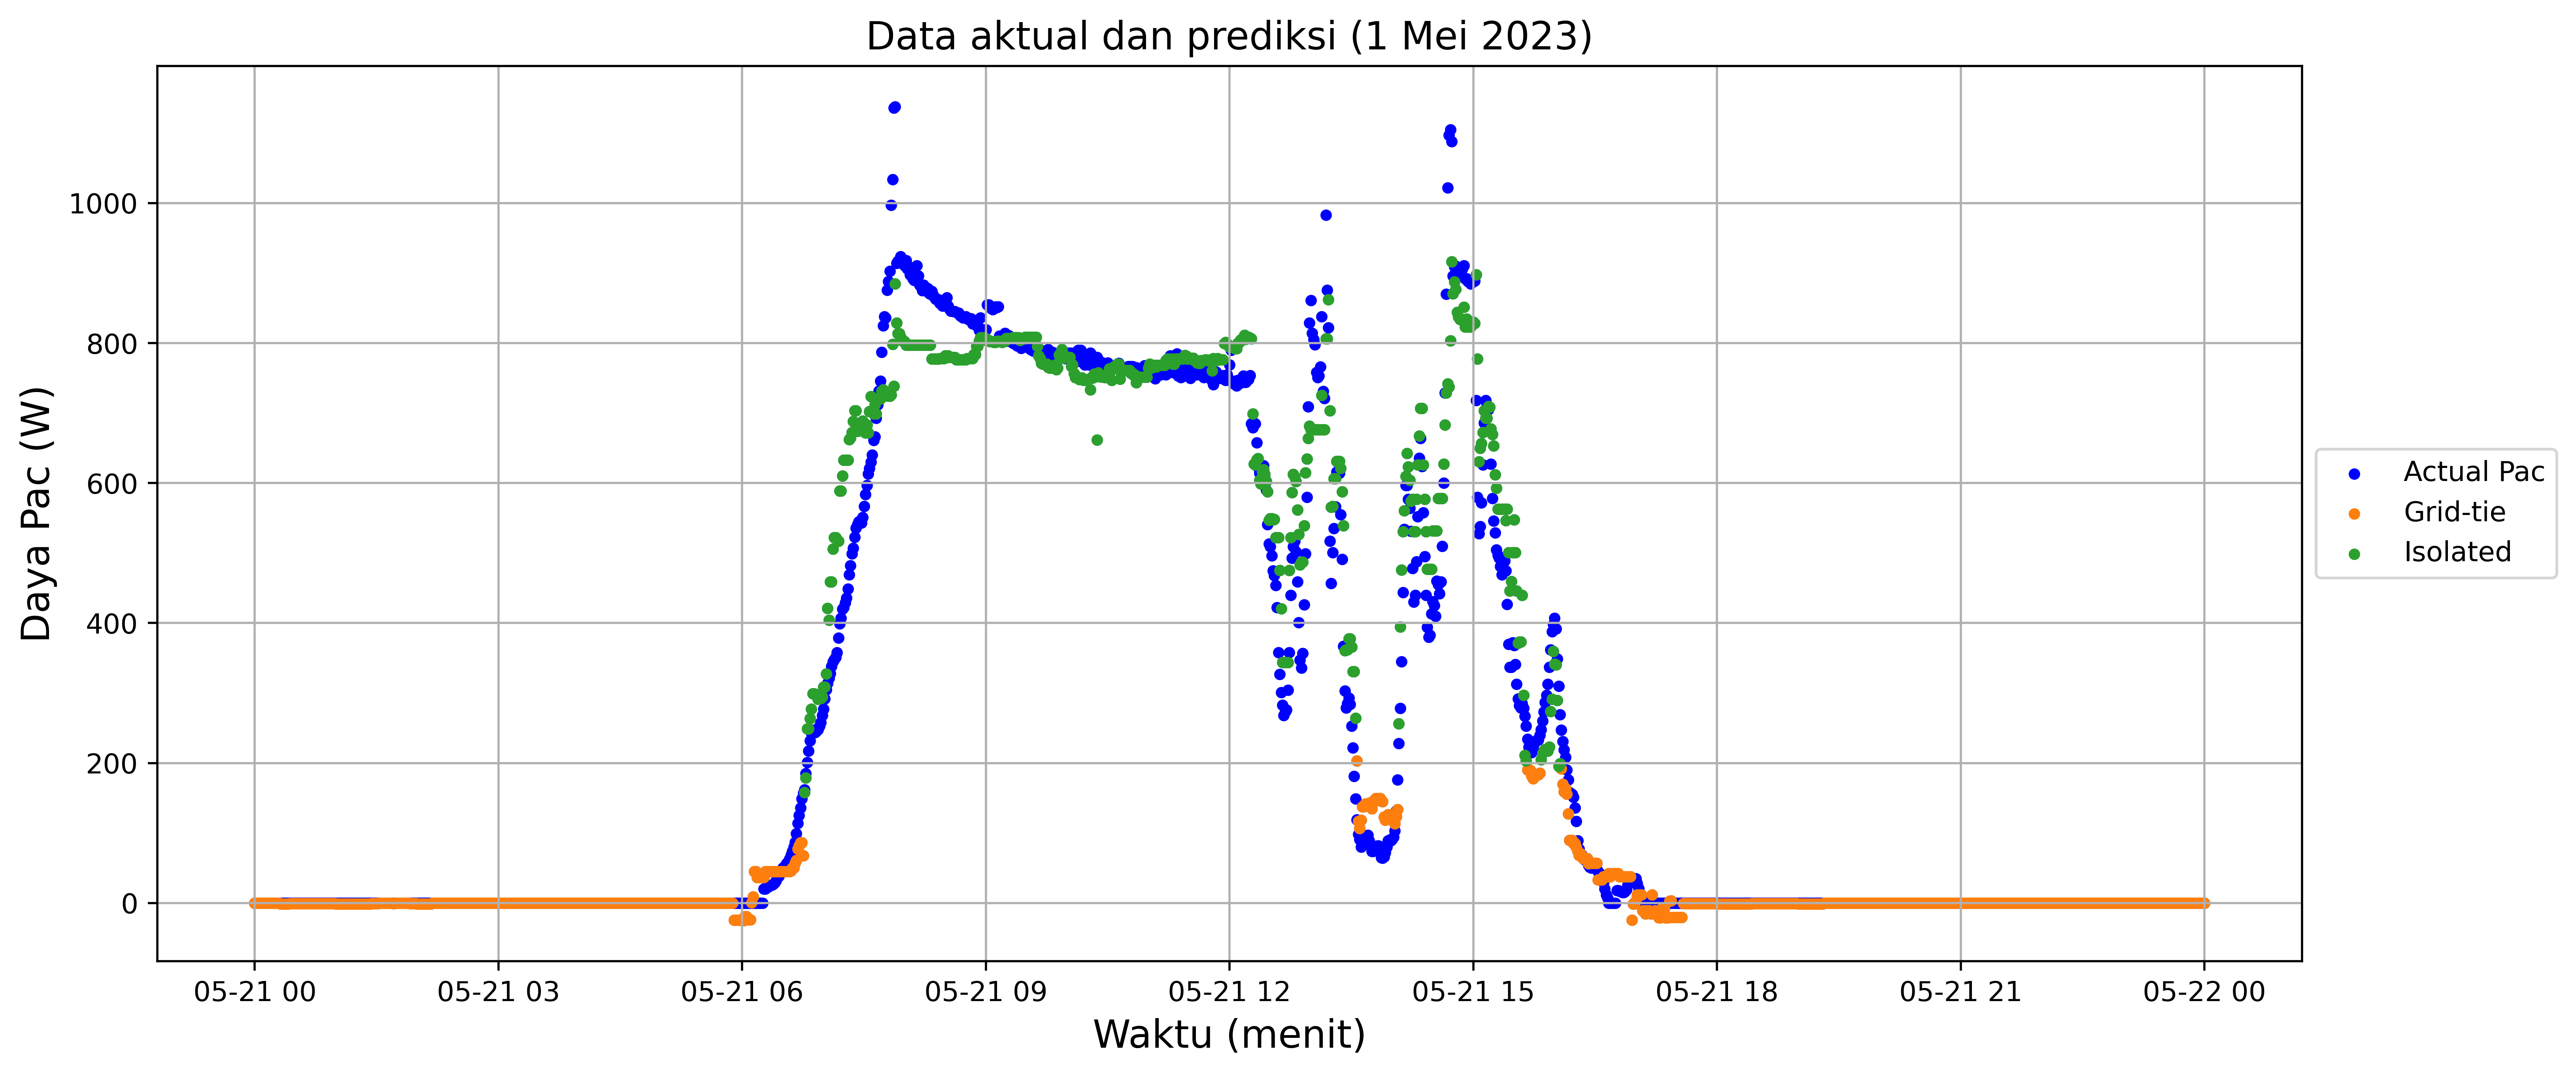

In [126]:

# Buat dataframe untuk menyimpan hasil prediksi
predictions_df = pd.DataFrame({
    'Timestamp': X_test_reg.index,  # Gunakan index sebagai timestamp
    'Actual_Pac': y_test_reg,  # Data aktual Pac
    'Predicted_Pac': y_pred_reg,  # Hasil prediksi Pac
    'Predicted_Status': y_pred_clf  # Hasil prediksi status operasi
})

# Pilih data hanya untuk satu bulan (misalnya, Oktober 2022)
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_data = predictions_df[(predictions_df['Timestamp'] >= start_date) & (predictions_df['Timestamp'] <= end_date)]

# Plot hasil prediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Scatter plot untuk Pac aktual
ax.scatter(filtered_data['Timestamp'], filtered_data['Actual_Pac'], label="Actual Pac", color='blue', s=10)

# Scatter plot untuk Pac yang diprediksi
ax.scatter(filtered_data['Timestamp'], filtered_data['Predicted_Pac'], s=10) #, label="Predicted Pac"

# Scatter plot untuk status operasi yang diprediksi
for status in filtered_data['Predicted_Status'].unique():
    status_data = filtered_data[filtered_data['Predicted_Status'] == status]
    label = "Grid-tie" if status == 0 else "Isolated"
    ax.scatter(status_data['Timestamp'], status_data['Predicted_Pac'], label=label, s=10)

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (1 Mei 2023)", fontsize=14)
ax.grid()

# Menampilkan legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Menyimpan plot ke file gambar
plt.savefig('Model1b.png')

# Menampilkan plot
plt.show()


In [127]:
# Filter hasil prediksi regresi yang negatif
negative_predictions_reg = y_pred_reg[y_pred_reg < 0]

# Print hasil prediksi regresi yang negatif
print("Hasil Prediksi Regresi yang Negatif:", negative_predictions_reg)
# Hitung jumlah baris hasil prediksi regresi yang negatif
jumlah_baris_negatif_reg = negative_predictions_reg.shape[0]

# Print jumlah baris hasil prediksi regresi yang negatif
print("Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif:", jumlah_baris_negatif_reg)


Hasil Prediksi Regresi yang Negatif: [ -5.033469  -5.033469  -5.033469 ... -13.924129 -13.924129 -13.924129]
Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif: 17956


In [137]:
from datetime import time

# Filter data untuk rentang waktu dari jam 18.02 sampai 05.30
filtered_df = predictions_df[
    ((predictions_df['Timestamp'].dt.hour == 18) & (predictions_df['Timestamp'].dt.minute >= 4)) |  # Jam 18:02 atau lebih
    (predictions_df['Timestamp'].dt.hour > 18) |  # Jam setelah 18:00
    ((predictions_df['Timestamp'].dt.hour == 5) & (predictions_df['Timestamp'].dt.minute <= 30))  # Jam 05:30 atau kurang
]

# Filter data dengan Predicted_Pac tidak nol
nonzero_predictions = filtered_df[filtered_df['Predicted_Pac'] != 0]

# Print informasi untuk Predicted_Pac tidak nol
print("Jumlah baris dengan Predicted_Pac tidak nol pada rentang waktu 18.02-05.30:", nonzero_predictions.shape[0])
print("Detail prediksi tidak nol:")
#for index, row in nonzero_predictions.iterrows():
 #   print(f"Baris ke-{index}, Tanggal: {row['Timestamp'].date()}, Jam: {row['Timestamp'].time()}, Predicted_Pac: {row['Predicted_Pac']}")


Jumlah baris dengan Predicted_Pac tidak nol pada rentang waktu 18.02-05.30: 20510
Detail prediksi tidak nol:


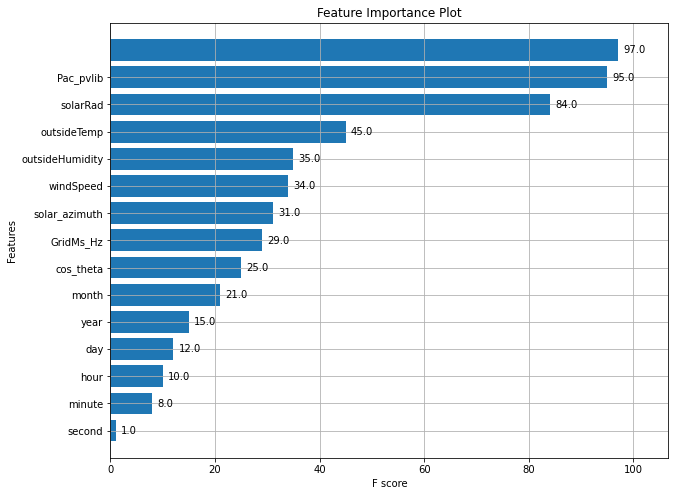

<Figure size 432x288 with 0 Axes>

In [129]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Dapatkan nama fitur numerik dari ColumnTransformer
numeric_features_reg = model_reg.best_estimator_.named_steps['prep'].transformers_[0][2]

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model_reg.best_estimator_.named_steps['algo'], ax=ax, max_num_features=15, height=0.8)
plt.title('Feature Importance Plot')
plt.yticks(range(len(numeric_features_reg)), numeric_features_reg[::-1])
plt.show()
plt.savefig('feature_importanceModel1b.png')

In [130]:
predictions_df.to_csv('modeluji1.csv')

In [131]:
# Gabungkan model-regresi dan model-klasifikasi serta nama file model menjadi satu objek
combined_models = {
    'regression_model': model_reg,
    'regression_model_file': 'regression_model.pkl',
    'classification_model': model_clf,
    'classification_model_file': 'classification_model.pkl'
}

# Simpan objek combined_models ke dalam file
joblib.dump(combined_models, 'Modelkondisi1baru.pkl')

['Modelkondisi1baru.pkl']

# Testing Data Baru

In [132]:
# Memuat kembali objek combined_models dari file
loaded_combined_models = joblib.load('Modelkondisi1baru.pkl')

# Mendapatkan model-regresi
loaded_model_reg = loaded_combined_models['regression_model']

# Mendapatkan nama file model-regresi
loaded_model_reg_file = loaded_combined_models['regression_model_file']

# Mendapatkan model-klasifikasi
loaded_model_clf = loaded_combined_models['classification_model']

# Mendapatkan nama file model-klasifikasi
loaded_model_clf_file = loaded_combined_models['classification_model_file']

In [133]:
#validasi

In [134]:
validasi.columns

Index(['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'Pac', 'Op_GriSwStt', 'GridMs_Hz', 'cos_theta',
       'month', 'year', 'day', 'hour', 'minute', 'second'],
      dtype='object')

In [135]:
# Test set untuk regresi
X_validasi_reg2 = validasi.drop(columns=['Pac'])
y_validasi_reg2 = validasi['Pac']
# Test set untuk klasifikasi
X_validasi_clf2 = validasi.drop(columns=['Op_GriSwStt'])
y_validasi_clf2 = validasi['Op_GriSwStt']

In [138]:
import time
# Mulai waktu
start_time = time.time()

df2_pred = loaded_model_reg.predict(X_validasi_reg2)

# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 0.19087982177734375 seconds


In [139]:
print("r2_score",r2_score(y_validasi_reg2,df2_pred))
rmse=np.sqrt(mean_squared_error(y_validasi_reg2,df2_pred))
MAE=mean_absolute_error(y_validasi_reg2, df2_pred)
absolute_percentage_error_reg = np.abs((y_validasi_reg2 - df2_pred) / np.maximum(np.abs(y_validasi_reg2), 1)) * 100
mape_reg = np.mean(np.where(np.isfinite(absolute_percentage_error_reg), absolute_percentage_error_reg, 0))

print('RMSE prediksi/estimasi pada data tes=',rmse)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('Mean Absolute Percentage Error on Test Set: ', mape_reg, '%')

# Menghitung rata-rata dari data aktual dan hasil prediksi
actual_mean = np.mean(y_validasi_reg2)
predicted_mean = np.mean(df2_pred)

# Menghitung bias
bias = actual_mean - predicted_mean

print('Rata-rata Actual:', actual_mean)
print('Rata-rata Predicted:', predicted_mean)
print('Bias:', bias)

r2_score 0.7296717437860855
RMSE prediksi/estimasi pada data tes= 235.5858798351144
MAE prekdisi/estimasi pada data tes= 93.94037668474284
Mean Absolute Percentage Error on Test Set:  632.8031581083263 %
Rata-rata Actual: 328.24722540156125
Rata-rata Predicted: 259.5215
Bias: 68.72571050898313


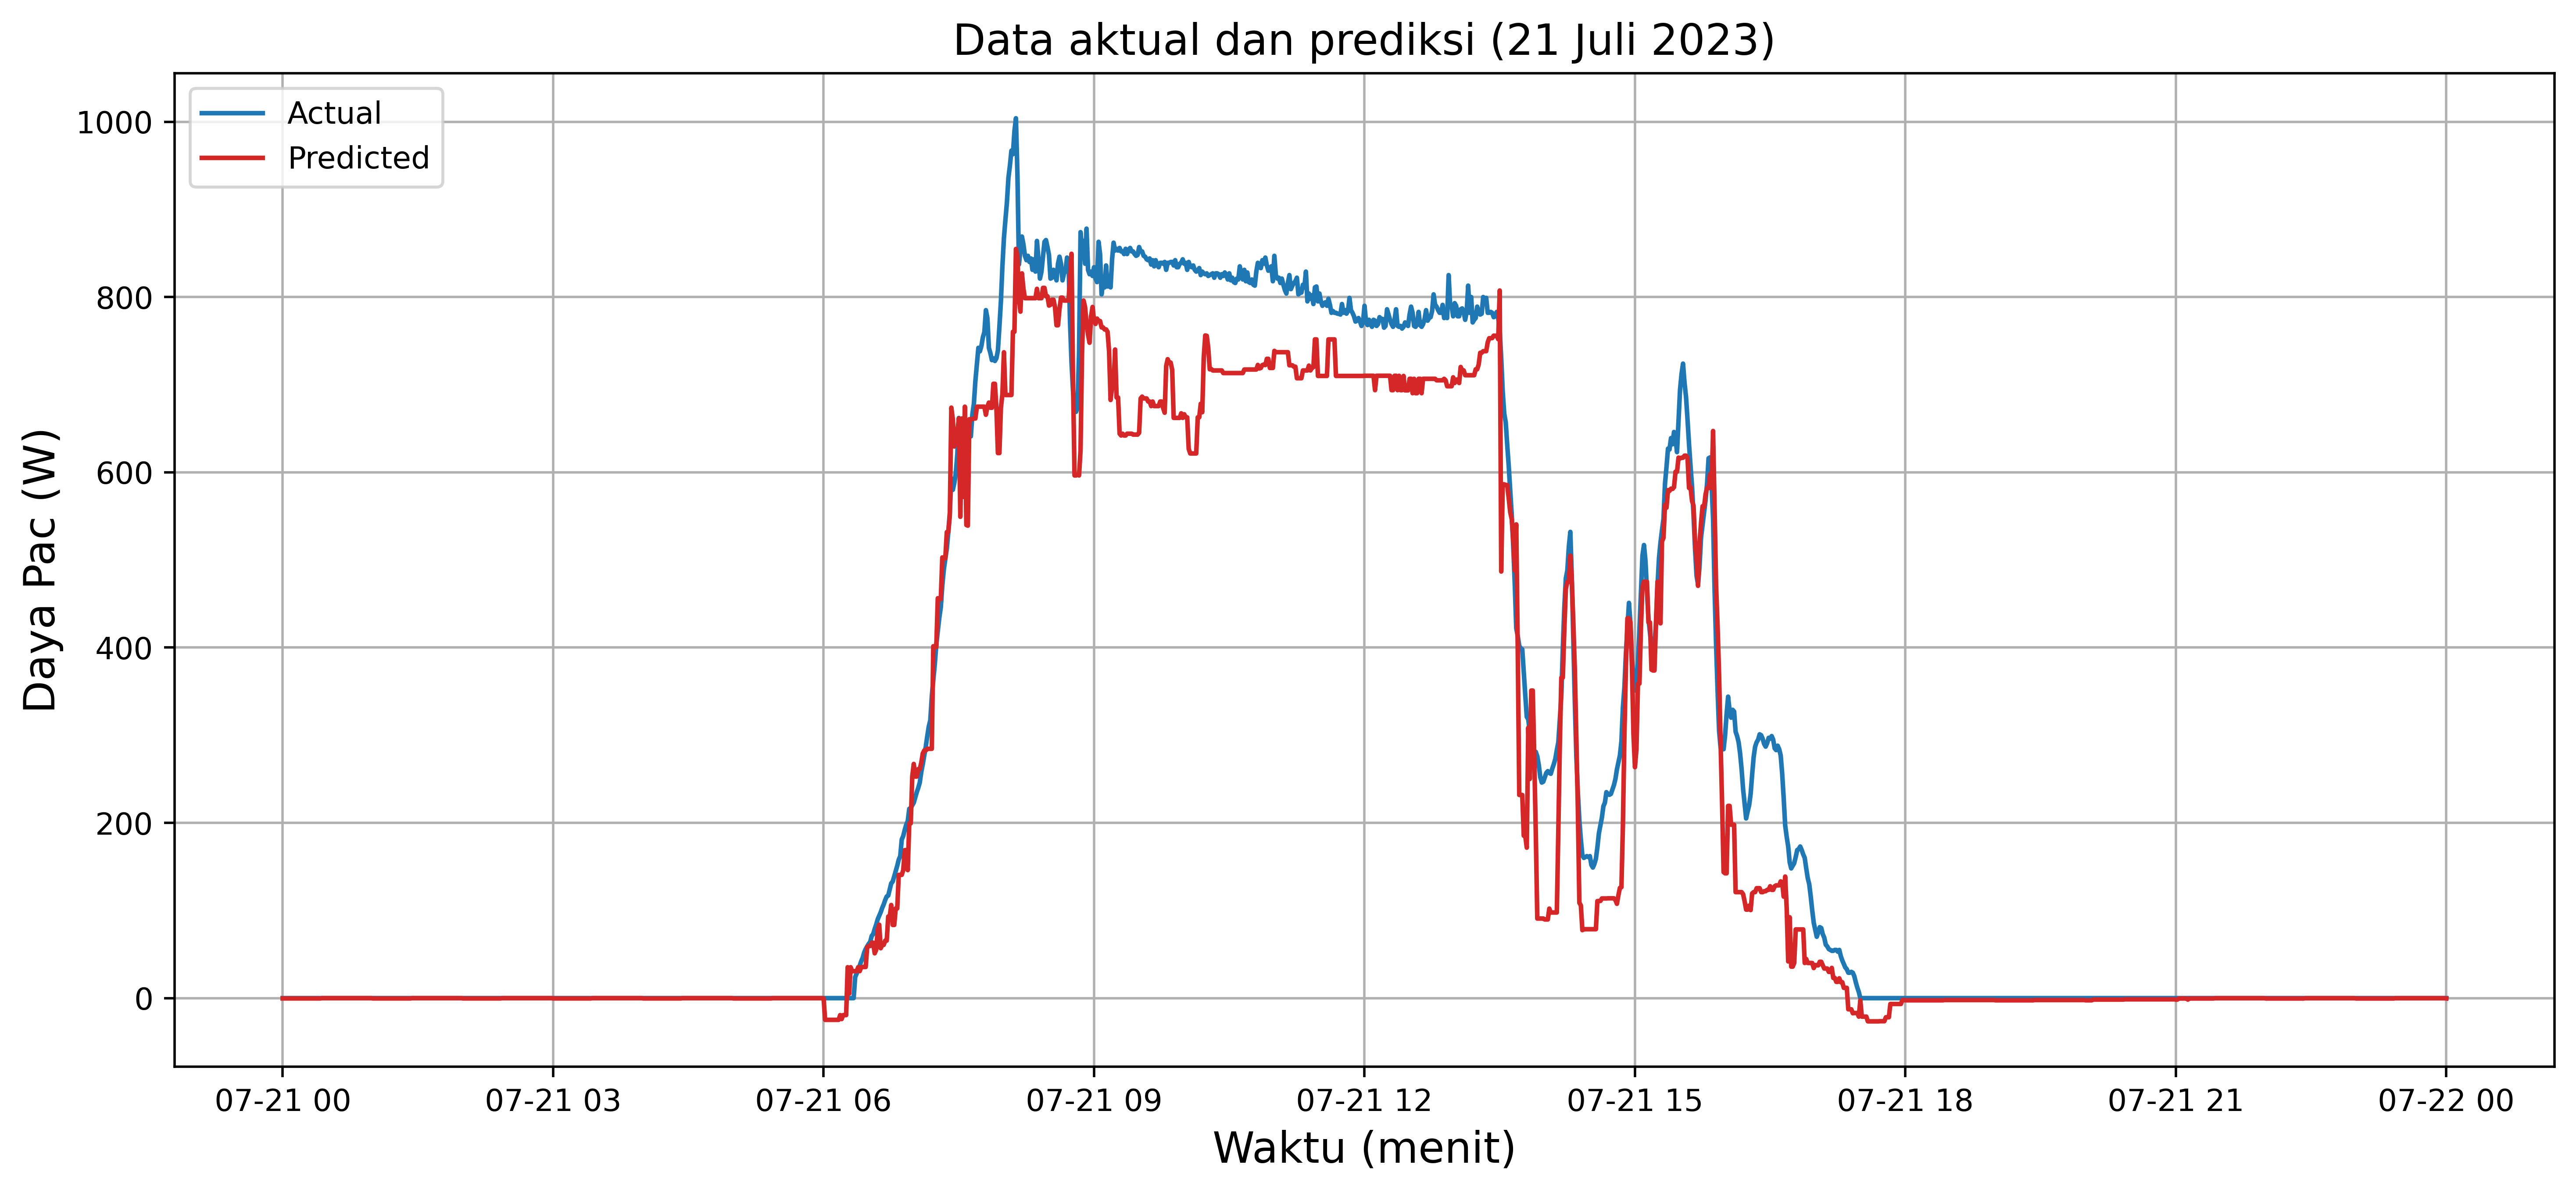

In [140]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df2 = pd.DataFrame(df2_pred, index=y_validasi_reg2.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-7-21'
end_date = '2023-7-22'
filtered_actual2 = y_validasi_reg2[(y_validasi_reg2.index >= start_date) & (y_validasi_reg2.index <= end_date)]
filtered_predicted2 = y_pred_reg_df2[(y_pred_reg_df2.index >= start_date) & (y_pred_reg_df2.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual2.index, filtered_actual2, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted2.index, filtered_predicted2.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (21 Juli 2023)", fontsize=14)
ax.grid()

# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
plt.savefig('Model1c.png')

# Menampilkan plot
plt.show()


In [141]:
# Filter hasil prediksi regresi yang negatif
negative_predictions_reg2 = df2_pred[df2_pred < 0]

# Print hasil prediksi regresi yang negatif
print("Hasil Prediksi Regresi yang Negatif:", negative_predictions_reg)
# Hitung jumlah baris hasil prediksi regresi yang negatif
jumlah_baris_negatif_reg2 = negative_predictions_reg2.shape[0]

# Print jumlah baris hasil prediksi regresi yang negatif
print("Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif:", jumlah_baris_negatif_reg2)


Hasil Prediksi Regresi yang Negatif: [ -5.033469  -5.033469  -5.033469 ... -13.924129 -13.924129 -13.924129]
Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif: 14276


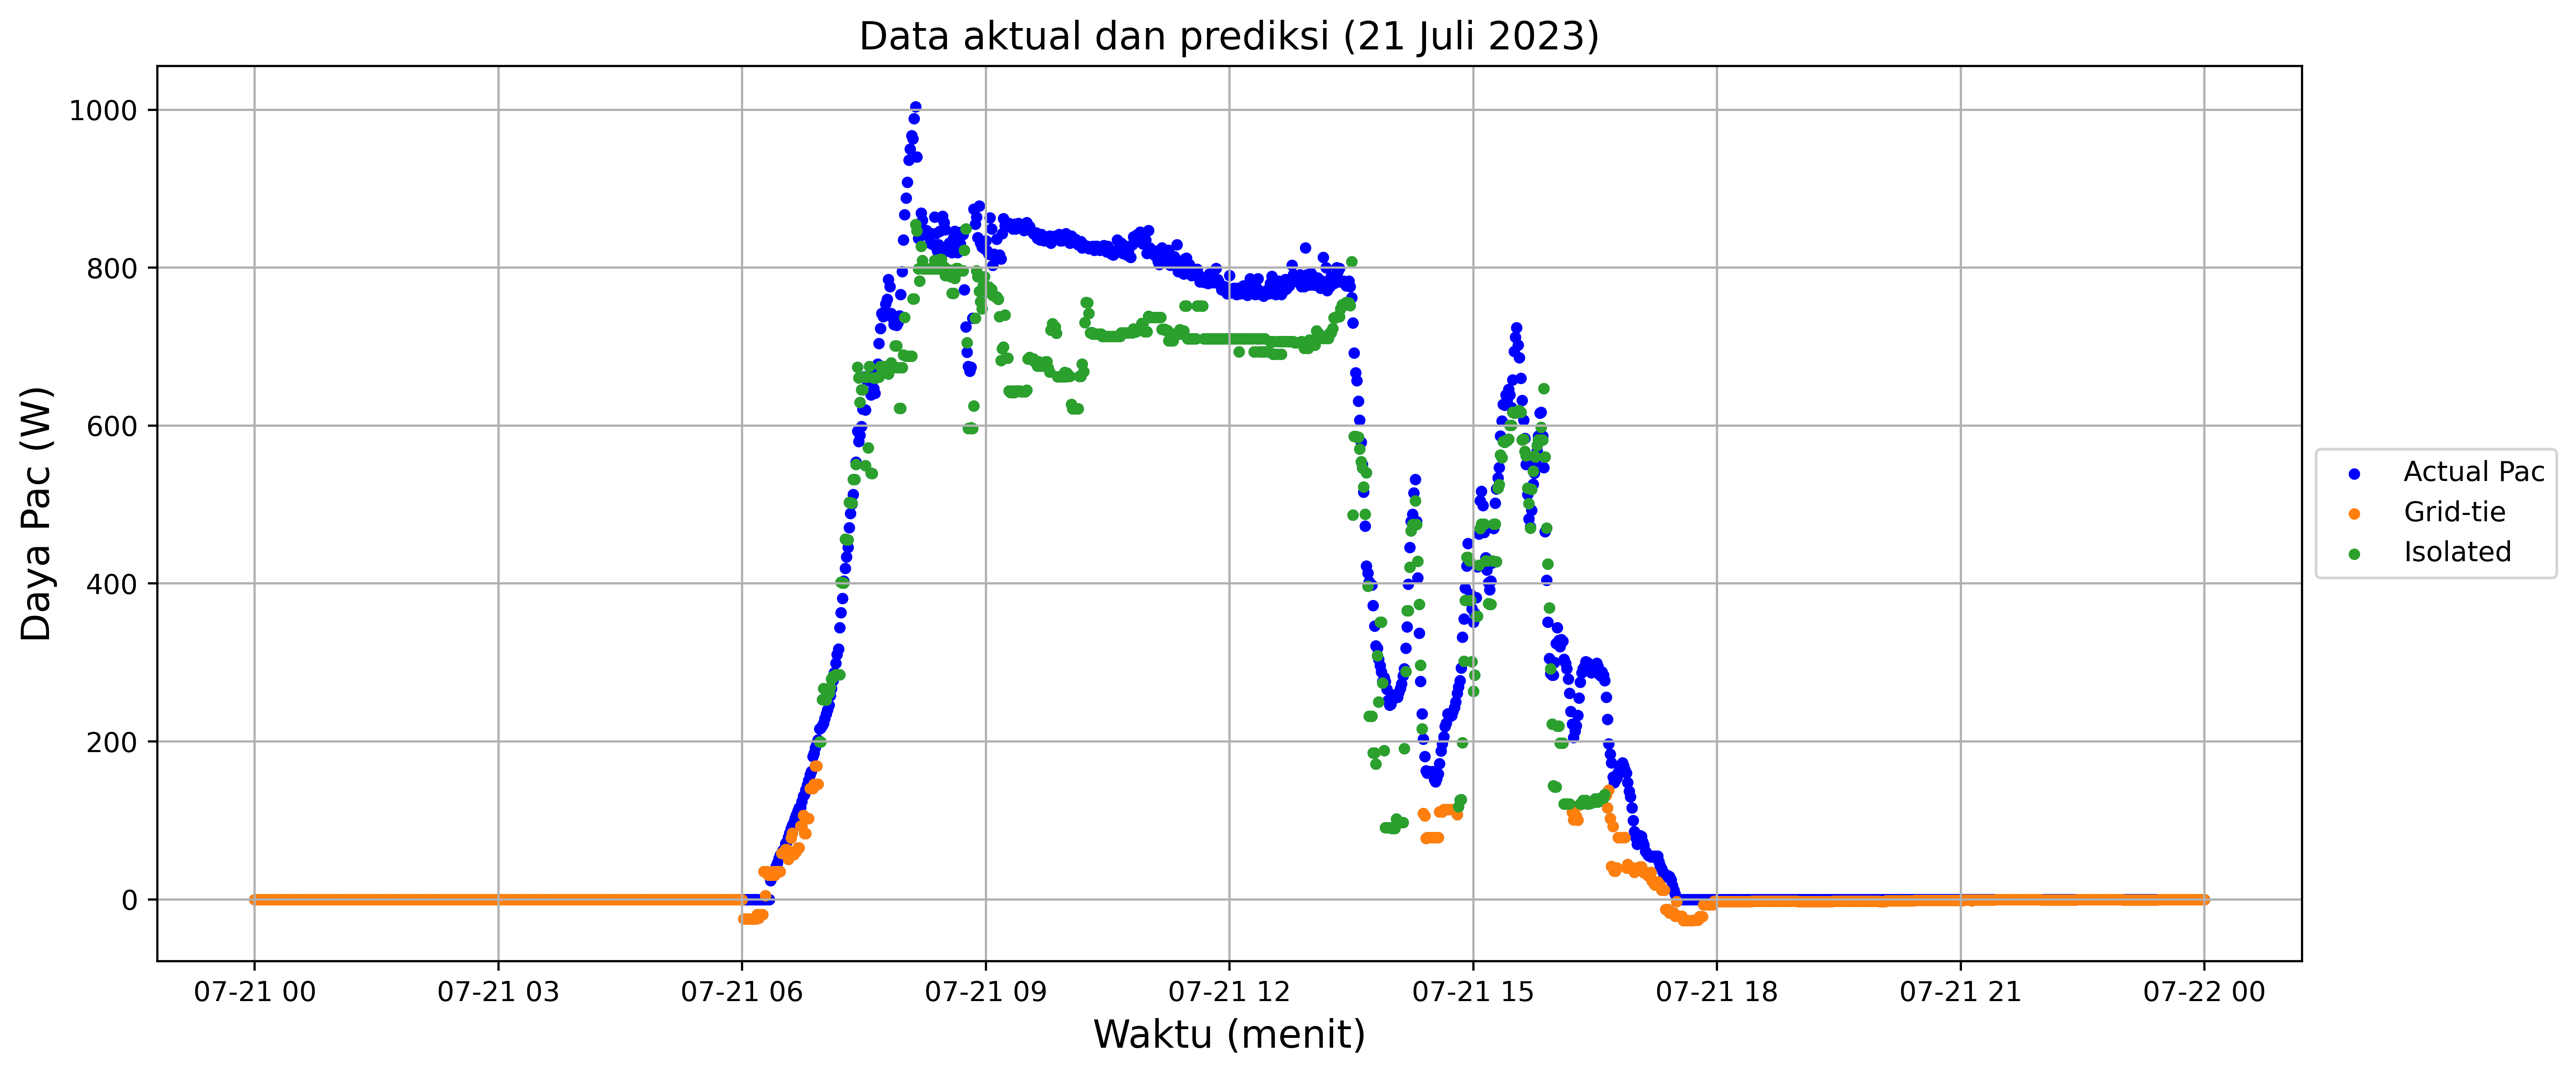

In [142]:
# Prediksi status operasi untuk setiap dataset (X_test_reg dan X_test_clf)
y_pred_clf2 = model_clf.predict(X_validasi_reg2)
# Buat dataframe untuk menyimpan hasil prediksi
predictions_df2 = pd.DataFrame({
    'Timestamp': X_validasi_reg2.index,  # Gunakan index sebagai timestamp
    'Actual_Pac': y_validasi_reg2,  # Data aktual Pac
    'Predicted_Pac': df2_pred,  # Hasil prediksi Pac
    'Predicted_Status': y_pred_clf2  # Hasil prediksi status operasi
})

# Pilih data hanya untuk satu bulan (misalnya, Oktober 2022)
start_date = '2023-7-21'
end_date = '2023-7-22'
filtered_data3 = predictions_df2[(predictions_df2['Timestamp'] >= start_date) & (predictions_df2['Timestamp'] <= end_date)]

# Plot hasil prediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

   
# Scatter plot untuk Pac aktual
ax.scatter(filtered_data3['Timestamp'], filtered_data3['Actual_Pac'], label="Actual Pac", color='blue', s=10)

# Scatter plot untuk Pac yang diprediksi
ax.scatter(filtered_data3['Timestamp'], filtered_data3['Predicted_Pac'], s=10) #, label="Predicted Pac"

# Scatter plot untuk status operasi yang diprediksi
for status in filtered_data3['Predicted_Status'].unique():
    status_data = filtered_data3[filtered_data3['Predicted_Status'] == status]
    label = "Grid-tie" if status == 0 else "Isolated"
    ax.scatter(status_data['Timestamp'], status_data['Predicted_Pac'], label=label, s=10)
    
# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (21 Juli 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Menyimpan plot ke file gambar
plt.savefig('Model1d.png')

# Menampilkan plot
plt.show()

In [143]:
# Evaluate classification model
accuracy_clf = accuracy_score(y_validasi_clf2, y_pred_clf2)
precision_clf = precision_score(y_validasi_clf2, y_pred_clf2)
recall_clf = recall_score(y_validasi_clf2, y_pred_clf2)
f1_clf = f1_score(y_validasi_clf2, y_pred_clf2)

print('Classification Model Metrics:')
print('Accuracy: ', accuracy_clf)
print('Precision: ', precision_clf)
print('Recall: ', recall_clf)
print('F1 Score: ', f1_clf)

Classification Model Metrics:
Accuracy:  0.899574325801515
Precision:  0.880208830738866
Recall:  0.8723498233215548
F1 Score:  0.8762617059373464


In [144]:
# Buat dataframe untuk menyimpan hasil prediksi
predictions_df2 = pd.DataFrame({
    'Timestamp': X_test_reg.index,  # Gunakan index sebagai timestamp
    'Actual_Pac': y_test_reg,  # Data aktual Pac
    'Predicted_Pac': y_pred_reg,  # Hasil prediksi Pac
    'Predicted_Status': y_pred_clf,  # Hasil prediksi status operasi
    'costheta': X_test_reg['cos_theta']  # Menambahkan kolom costheta
})

In [146]:
predictions_df2.to_csv('model1validasi.csv')